In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
import matplotlib.pyplot as plt
from tensorflow import keras
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.optimizers import RMSprop
from keras.layers import Activation
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import ZeroPadding2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
import pickle

# Import Tensorflow with multiprocessing
import tensorflow as tf
import multiprocessing as mp
from keras import regularizers
from tensorflow.keras import metrics

# Loading the CIFAR-10 datasets
from keras.datasets import cifar10
from keras.datasets import mnist



In [2]:
from keras.datasets import mnist
import numpy as np
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)
#x_train = (x_train).reshape(-1,28,28)
#x_test =  (x_test).reshape(-1,28,28)
input_shape = x_train.shape[1:]
print(input_shape)
X_train = x_train
X_test = x_test
Y_train = y_train
Y_test = y_test

11493376/11490434 [==============================] - 0s 0us/step
(60000, 784)
(10000, 784)
(784,)


In [3]:
print(X_train)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [4]:
print(X_test)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [5]:
from __future__ import absolute_import
from __future__ import print_function

import random
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda
from keras.optimizers import RMSprop
from keras import backend as K

## **CONTRASTIVE LOSS**

In [ ]:
def compute_accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))
def accuracy(y_true,y_pred):
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)    
def eucliddist(X,y):
  dist =  K.sum(K.square(X - y), axis=1, keepdims=True)
  return dist
def euclid(values):
  X,y = values
  dist = eucliddist(X,y)
  return K.sqrt(K.maximum(dist, K.epsilon()))
def euclidshape(shapes):
  shape1, shape2 = shapes
  return (shape1[0], 1)
def loss1(Y_real,Y_predicted):
    # Y_predicted = tf.dtypes.cast(Y_predicted, tf.int64)
    # print(Y_predicted.dtype)
    # print(Y_real.dtype)
    margin = 1
    sqaureprediction = K.square(Y_predicted)
    marginsquare = K.square(K.maximum(margin - Y_predicted, 0))
    return K.mean(Y_real * sqaureprediction + (1 - Y_real) * marginsquare)
def paircreation(X,digitindices):
  pairs = []
  labels = []
  n = min([len(digitindices[d]) for d in range(10)]) - 1    
  i = 0
  while(i<10):
    j = 0
    while(j<n):
      z1 = digitindices[i][j]
      z2 = digitindices[i][j + 1]
      pairs += [[X[z1], X[z2]]]
      inc = random.randrange(1, 10)
      dn = (i + inc) % 10
      z1, z2 = digitindices[i][j], digitindices[dn][j]
      pairs += [[X[z1], X[z2]]]
      labels += [1, 0]    
      j = j+1
    i = i+1
  return np.array(pairs), np.array(labels)
def base_model(inputshape):
    input = Input(shape=inputshape)
    x = Dense(64, activation='relu')(input)
    x = Dense(128, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    x = Lambda(lambda  x: K.l2_normalize(x,axis=1))(x)
    x = Lambda(lambda  x: K.l2_normalize(x,axis=1))(x)
    return Model(input,x)
digitindices = [np.where(Y_train == i)[0] for i in range(10)]
tr_pairs, tr_y = paircreation(X_train, digitindices)
tr_y = tr_y.astype("float32")
#print(tr_pairs,tr_y)
digitindices = [np.where(Y_test == i)[0] for i in range(10)]
te_pairs, te_y = paircreation(X_test, digitindices)
te_y = te_y.astype("float32")
#print(te_pairs,te_y)
modelbase = base_model(input_shape)
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)
processeda = modelbase(input_a)
processedb = modelbase(input_b)
distance = Lambda(euclid,output_shape=euclidshape)([processeda, processedb])
MOdel = Model([input_a, input_b], distance)    
rms = RMSprop()
MOdel.compile(loss=loss1, optimizer=rms, metrics=[compute_accuracy])
history = MOdel.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,batch_size=128,epochs=10,validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))
y_pred_tr = MOdel.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
y_pred_te = MOdel.predict([te_pairs[:, 0], te_pairs[:, 1]])
print(len(y_pred_tr))
print(len(y_pred_te))
trainaccuracy = accuracy(tr_y, y_pred_tr)
testaccuracy =  accuracy(te_y, y_pred_te) 
print('* Accuracy on training set: %0.2f%%' % (100 * trainaccuracy))
print('* Accuracy on test set: %0.2f%%' % (100 * testaccuracy))


Epoch 1/10
847/847 [==============================] - 8s 8ms/step - loss: 0.0895 - compute_accuracy: 0.8893 - val_loss: 0.0368 - val_compute_accuracy: 0.9590
Epoch 2/10
847/847 [==============================] - 7s 8ms/step - loss: 0.0289 - compute_accuracy: 0.9683 - val_loss: 0.0255 - val_compute_accuracy: 0.9692
Epoch 3/10
847/847 [==============================] - 7s 8ms/step - loss: 0.0183 - compute_accuracy: 0.9799 - val_loss: 0.0247 - val_compute_accuracy: 0.9698
Epoch 4/10
847/847 [==============================] - 7s 8ms/step - loss: 0.0139 - compute_accuracy: 0.9845 - val_loss: 0.0233 - val_compute_accuracy: 0.9711
Epoch 5/10
847/847 [==============================] - 7s 8ms/step - loss: 0.0110 - compute_accuracy: 0.9878 - val_loss: 0.0240 - val_compute_accuracy: 0.9693
Epoch 6/10
847/847 [==============================] - 7s 8ms/step - loss: 0.0092 - compute_accuracy: 0.9899 - val_loss: 0.0224 - val_compute_accuracy: 0.9711
Epoch 7/10
847/847 [==============================] 

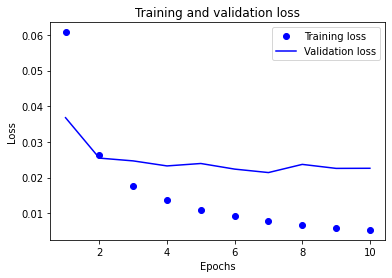

In [ ]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, (len(history.history['val_compute_accuracy']) + 1))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# **Triplet Loss**

In [7]:
!pip install -q -U tensorflow-addons

     |████████████████████████████████| 706kB 5.0MB/s 


In [ ]:
import tensorflow_addons as tfa
def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))
def accuracy1(y_true,y_pred):
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true) 
def eucliddist(X,y):
  dist =  K.sum(K.square(X - y), axis=1, keepdims=True)
  return dist
def euclid(values):
  X,y = values
  dist = eucliddist(X,y)
  return K.sqrt(K.maximum(dist, K.epsilon()))
def euclidshape(shapes):
  shape1, shape2 = shapes
  return (shape1[0], 1)
def loss1(Y_real,Y_predicted):
    # Y_predicted = tf.dtypes.cast(Y_predicted, tf.int64)
    # print(Y_predicted.dtype)
    # print(Y_real.dtype)
    margin = 1
    sqaureprediction = K.square(Y_predicted)
    marginsquare = K.square(K.maximum(margin - Y_predicted, 0))
    return K.mean(Y_real * sqaureprediction + (1 - Y_real) * marginsquare)
def paircreation(X,digitindices):
  pairs = []
  labels = []
  n = min([len(digitindices[d]) for d in range(10)]) - 1    
  i = 0
  while(i<10):
    j = 0
    while(j<n):
      z1 = digitindices[i][j]
      z2 = digitindices[i][j + 1]
      pairs += [[X[z1], X[z2]]]
      inc = random.randrange(1, 10)
      dn = (i + inc) % 10
      z1, z2 = digitindices[i][j], digitindices[dn][j]
      pairs += [[X[z1], X[z2]]]
      labels += [1, 0]    
      j = j+1
    i = i+1
  return np.array(pairs), np.array(labels)
def base_model(inputshape):
    input = Input(shape=inputshape)
    x = Dense(128, activation='relu')(input)
    x = Dense(128, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Lambda(lambda  x: K.l2_normalize(x,axis=1))(x)
    x = Lambda(lambda  x: K.l2_normalize(x,axis=1))(x)
    return Model(input,x)
digitindices = [np.where(Y_train == i)[0] for i in range(10)]
tr_pairs, tr_y = paircreation(X_train, digitindices)
tr_y = tr_y.astype("float32")
#print(tr_pairs,tr_y)
digitindices = [np.where(Y_test == i)[0] for i in range(10)]
te_pairs, te_y = paircreation(X_test, digitindices)
te_y = te_y.astype("float32")
#print(te_pairs,te_y)
modelbase = base_model(input_shape)
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)
processeda = modelbase(input_a)
processedb = modelbase(input_b)
distance = Lambda(euclid,output_shape=euclidshape)([processeda, processedb])
MOdel = Model([input_a, input_b], distance)    
rms = RMSprop()
MOdel.compile(loss=tfa.losses.TripletSemiHardLoss(), optimizer=rms, metrics=[accuracy])
history = MOdel.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,batch_size=128,epochs=10,validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))
y_pred_tr = MOdel.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
y_pred_te = MOdel.predict([te_pairs[:, 0], te_pairs[:, 1]])



trainaccuracy = accuracy1(tr_y, y_pred_tr)
testaccuracy = accuracy1(te_y, y_pred_te) 
print('* Accuracy on training set: %0.2f%%' % (100 * trainaccuracy))
print('* Accuracy on test set: %0.2f%%' % (100 * testaccuracy))


Epoch 1/10
847/847 [==============================] - 69s 79ms/step - loss: 0.9171 - accuracy: 0.8067 - val_loss: 0.6075 - val_accuracy: 0.9209
Epoch 2/10
847/847 [==============================] - 63s 75ms/step - loss: 0.6981 - accuracy: 0.9271 - val_loss: 0.5963 - val_accuracy: 0.9208
Epoch 3/10
847/847 [==============================] - 58s 69ms/step - loss: 0.5868 - accuracy: 0.9510 - val_loss: 0.4494 - val_accuracy: 0.9541
Epoch 4/10
847/847 [==============================] - 55s 65ms/step - loss: 0.4908 - accuracy: 0.9648 - val_loss: 0.4410 - val_accuracy: 0.9590
Epoch 5/10
847/847 [==============================] - 48s 57ms/step - loss: 0.4293 - accuracy: 0.9695 - val_loss: 0.4432 - val_accuracy: 0.9573
Epoch 6/10
847/847 [==============================] - 50s 59ms/step - loss: 0.3839 - accuracy: 0.9748 - val_loss: 0.4378 - val_accuracy: 0.9589
Epoch 7/10
847/847 [==============================] - 47s 56ms/step - loss: 0.3207 - accuracy: 0.9793 - val_loss: 0.4000 - val_accuracy:

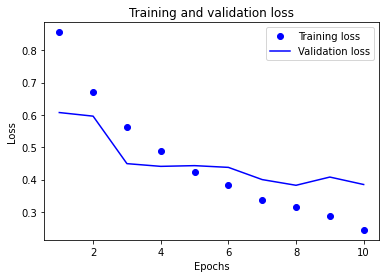

In [ ]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, (len(history.history['val_accuracy']) + 1))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# **Regularized Cross Entropy**

In [11]:
import tensorflow_addons as tfa
def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))
def accuracy1(y_true,y_pred):
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true) 
def eucliddist(X,y):
  dist =  K.sum(K.square(X - y), axis=1, keepdims=True)
  return dist
def euclid(values):
  X,y = values
  dist = eucliddist(X,y)
  return K.sqrt(K.maximum(dist, K.epsilon()))
def euclidshape(shapes):
  shape1, shape2 = shapes
  return (shape1[0], 1)
def loss1(Y_real,Y_predicted):
    # Y_predicted = tf.dtypes.cast(Y_predicted, tf.int64)
    # print(Y_predicted.dtype)
    # print(Y_real.dtype)
    margin = 1
    sqaureprediction = K.square(Y_predicted)
    marginsquare = K.square(K.maximum(margin - Y_predicted, 0))
    return K.mean(Y_real * sqaureprediction + (1 - Y_real) * marginsquare)
def paircreation(X,digitindices):
  pairs = []
  labels = []
  n = min([len(digitindices[d]) for d in range(10)]) - 1    
  i = 0
  while(i<10):
    j = 0
    while(j<n):
      z1 = digitindices[i][j]
      z2 = digitindices[i][j + 1]
      pairs += [[X[z1], X[z2]]]
      inc = random.randrange(1, 10)
      dn = (i + inc) % 10
      z1, z2 = digitindices[i][j], digitindices[dn][j]
      pairs += [[X[z1], X[z2]]]
      labels += [1, 0]    
      j = j+1
    i = i+1
  return np.array(pairs), np.array(labels)
def base_model(inputshape):
    input = Input(shape=inputshape)
    x = Dense(128, activation='relu')(input)
    x = Dense(128, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Lambda(lambda  x: K.l2_normalize(x,axis=1))(x)
    x = Lambda(lambda  x: K.l2_normalize(x,axis=1))(x)
    return Model(input,x)
digitindices = [np.where(Y_train == i)[0] for i in range(10)]
tr_pairs, tr_y = paircreation(X_train, digitindices)
tr_y = tr_y.astype("float32")
#print(tr_pairs,tr_y)
digitindices = [np.where(Y_test == i)[0] for i in range(10)]
te_pairs, te_y = paircreation(X_test, digitindices)
te_y = te_y.astype("float32")
#print(te_pairs,te_y)
modelbase = base_model(input_shape)
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)
processeda = modelbase(input_a)
processedb = modelbase(input_b)
distance = Lambda(euclid,output_shape=euclidshape)([processeda, processedb])
MOdel = Model([input_a, input_b], distance)    
adm = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
MOdel.compile(loss='categorical_crossentropy', metrics=[accuracy],optimizer = 'RMSProp')
#MOdel.compile(loss=tfa.losses.TripletSemiHardLoss(), optimizer=rms, metrics=[accuracy])
history = MOdel.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,batch_size=128,epochs=10,validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))
y_pred_tr = MOdel.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
y_pred_te = MOdel.predict([te_pairs[:, 0], te_pairs[:, 1]])



trainaccuracy = accuracy1(tr_y, y_pred_tr)
testaccuracy = accuracy1(te_y, y_pred_te) 
print('* Accuracy on training set: %0.2f%%' % (100 * trainaccuracy))
print('* Accuracy on test set: %0.2f%%' % (100 * testaccuracy))


Epoch 1/10
847/847 [==============================] - 9s 9ms/step - loss: 5.9614e-08 - accuracy: 0.5635 - val_loss: 5.9605e-08 - val_accuracy: 0.5997
Epoch 2/10
847/847 [==============================] - 7s 9ms/step - loss: 5.9610e-08 - accuracy: 0.5630 - val_loss: 5.9605e-08 - val_accuracy: 0.5997
Epoch 3/10
847/847 [==============================] - 7s 9ms/step - loss: 5.9895e-08 - accuracy: 0.5607 - val_loss: 5.9605e-08 - val_accuracy: 0.5997
Epoch 4/10
847/847 [==============================] - 7s 9ms/step - loss: 5.9460e-08 - accuracy: 0.5628 - val_loss: 5.9605e-08 - val_accuracy: 0.5997
Epoch 5/10
847/847 [==============================] - 7s 9ms/step - loss: 5.9558e-08 - accuracy: 0.5621 - val_loss: 5.9605e-08 - val_accuracy: 0.5997
Epoch 6/10
847/847 [==============================] - 7s 9ms/step - loss: 5.9579e-08 - accuracy: 0.5640 - val_loss: 5.9605e-08 - val_accuracy: 0.5997
Epoch 7/10
847/847 [==============================] - 7s 9ms/step - loss: 5.9817e-08 - accuracy: 0.5

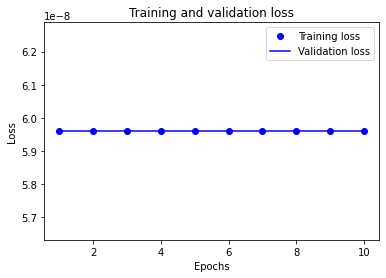

In [12]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, (len(history.history['val_accuracy']) + 1))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# **ACCURACY COMPARISION**

**TEST ACCURACY ON CONTRASTIVE LOSS - 97.21%**

**TEST ACCURACY ON TRIPLET LOSS - 97.69**

**TEST ACCURACY ON REGULARIZED CLASS ENTROPY - 59.84%**


# **ADAM OPTIMIZER**

In [ ]:
import tensorflow_addons as tfa
def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))
def accuracy1(y_true,y_pred):
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true) 
def eucliddist(X,y):
  dist =  K.sum(K.square(X - y), axis=1, keepdims=True)
  return dist
def euclid(values):
  X,y = values
  dist = eucliddist(X,y)
  return K.sqrt(K.maximum(dist, K.epsilon()))
def euclidshape(shapes):
  shape1, shape2 = shapes
  return (shape1[0], 1)
def loss1(Y_real,Y_predicted):
    # Y_predicted = tf.dtypes.cast(Y_predicted, tf.int64)
    # print(Y_predicted.dtype)
    # print(Y_real.dtype)
    margin = 1
    sqaureprediction = K.square(Y_predicted)
    marginsquare = K.square(K.maximum(margin - Y_predicted, 0))
    return K.mean(Y_real * sqaureprediction + (1 - Y_real) * marginsquare)
def paircreation(X,digitindices):
  pairs = []
  labels = []
  n = min([len(digitindices[d]) for d in range(10)]) - 1    
  i = 0
  while(i<10):
    j = 0
    while(j<n):
      z1 = digitindices[i][j]
      z2 = digitindices[i][j + 1]
      pairs += [[X[z1], X[z2]]]
      inc = random.randrange(1, 10)
      dn = (i + inc) % 10
      z1, z2 = digitindices[i][j], digitindices[dn][j]
      pairs += [[X[z1], X[z2]]]
      labels += [1, 0]    
      j = j+1
    i = i+1
  return np.array(pairs), np.array(labels)
def base_model(inputshape):
    input = Input(shape=inputshape)
    x = Dense(128, activation='relu')(input)
    x = Dense(128, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Lambda(lambda  x: K.l2_normalize(x,axis=1))(x)
    x = Lambda(lambda  x: K.l2_normalize(x,axis=1))(x)
    return Model(input,x)
digitindices = [np.where(Y_train == i)[0] for i in range(10)]
tr_pairs, tr_y = paircreation(X_train, digitindices)
tr_y = tr_y.astype("float32")
#print(tr_pairs,tr_y)
digitindices = [np.where(Y_test == i)[0] for i in range(10)]
te_pairs, te_y = paircreation(X_test, digitindices)
te_y = te_y.astype("float32")
#print(te_pairs,te_y)
modelbase = base_model(input_shape)
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)
processeda = modelbase(input_a)
processedb = modelbase(input_b)
distance = Lambda(euclid,output_shape=euclidshape)([processeda, processedb])
MOdel = Model([input_a, input_b], distance)    
adm = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
MOdel.compile(loss=tfa.losses.TripletSemiHardLoss(), optimizer=adm, metrics=[accuracy])
history = MOdel.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,batch_size=128,epochs=10,validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))
y_pred_tr = MOdel.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
y_pred_te = MOdel.predict([te_pairs[:, 0], te_pairs[:, 1]])



trainaccuracy = accuracy1(tr_y, y_pred_tr)
testaccuracy = accuracy1(te_y, y_pred_te) 
print('* Accuracy on training set: %0.2f%%' % (100 * trainaccuracy))
print('* Accuracy on test set: %0.2f%%' % (100 * testaccuracy))


Epoch 1/10
847/847 [==============================] - 52s 60ms/step - loss: 0.9242 - accuracy: 0.8079 - val_loss: 0.6834 - val_accuracy: 0.9086
Epoch 2/10
847/847 [==============================] - 54s 64ms/step - loss: 0.7299 - accuracy: 0.9201 - val_loss: 0.5727 - val_accuracy: 0.9392
Epoch 3/10
847/847 [==============================] - 53s 63ms/step - loss: 0.6252 - accuracy: 0.9455 - val_loss: 0.5431 - val_accuracy: 0.9438
Epoch 4/10
847/847 [==============================] - 55s 65ms/step - loss: 0.5620 - accuracy: 0.9578 - val_loss: 0.5363 - val_accuracy: 0.9424
Epoch 5/10
847/847 [==============================] - 54s 64ms/step - loss: 0.4835 - accuracy: 0.9654 - val_loss: 0.4950 - val_accuracy: 0.9539
Epoch 6/10
847/847 [==============================] - 52s 62ms/step - loss: 0.4431 - accuracy: 0.9709 - val_loss: 0.4474 - val_accuracy: 0.9574
Epoch 7/10
847/847 [==============================] - 53s 62ms/step - loss: 0.3795 - accuracy: 0.9746 - val_loss: 0.4437 - val_accuracy:

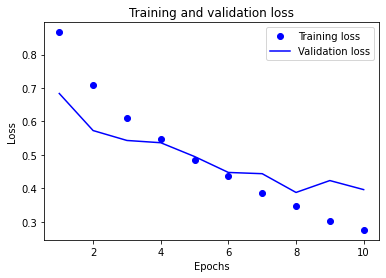

In [ ]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, (len(history.history['val_accuracy']) + 1))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# **RMSprop optimizer**

In [ ]:
import tensorflow_addons as tfa
def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))
def accuracy1(y_true,y_pred):
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true) 
def eucliddist(X,y):
  dist =  K.sum(K.square(X - y), axis=1, keepdims=True)
  return dist
def euclid(values):
  X,y = values
  dist = eucliddist(X,y)
  return K.sqrt(K.maximum(dist, K.epsilon()))
def euclidshape(shapes):
  shape1, shape2 = shapes
  return (shape1[0], 1)
def loss1(Y_real,Y_predicted):
    # Y_predicted = tf.dtypes.cast(Y_predicted, tf.int64)
    # print(Y_predicted.dtype)
    # print(Y_real.dtype)
    margin = 1
    sqaureprediction = K.square(Y_predicted)
    marginsquare = K.square(K.maximum(margin - Y_predicted, 0))
    return K.mean(Y_real * sqaureprediction + (1 - Y_real) * marginsquare)
def paircreation(X,digitindices):
  pairs = []
  labels = []
  n = min([len(digitindices[d]) for d in range(10)]) - 1    
  i = 0
  while(i<10):
    j = 0
    while(j<n):
      z1 = digitindices[i][j]
      z2 = digitindices[i][j + 1]
      pairs += [[X[z1], X[z2]]]
      inc = random.randrange(1, 10)
      dn = (i + inc) % 10
      z1, z2 = digitindices[i][j], digitindices[dn][j]
      pairs += [[X[z1], X[z2]]]
      labels += [1, 0]    
      j = j+1
    i = i+1
  return np.array(pairs), np.array(labels)
def base_model(inputshape):
    input = Input(shape=inputshape)
    x = Dense(128, activation='relu')(input)
    x = Dense(128, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Lambda(lambda  x: K.l2_normalize(x,axis=1))(x)
    x = Lambda(lambda  x: K.l2_normalize(x,axis=1))(x)
    return Model(input,x)
digitindices = [np.where(Y_train == i)[0] for i in range(10)]
tr_pairs, tr_y = paircreation(X_train, digitindices)
tr_y = tr_y.astype("float32")
#print(tr_pairs,tr_y)
digitindices = [np.where(Y_test == i)[0] for i in range(10)]
te_pairs, te_y = paircreation(X_test, digitindices)
te_y = te_y.astype("float32")
#print(te_pairs,te_y)
modelbase = base_model(input_shape)
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)
processeda = modelbase(input_a)
processedb = modelbase(input_b)
distance = Lambda(euclid,output_shape=euclidshape)([processeda, processedb])
MOdel = Model([input_a, input_b], distance)    
rms = RMSprop()
MOdel.compile(loss=tfa.losses.TripletSemiHardLoss(), optimizer=rms, metrics=[accuracy])
history = MOdel.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,batch_size=128,epochs=10,validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))
y_pred_tr = MOdel.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
y_pred_te = MOdel.predict([te_pairs[:, 0], te_pairs[:, 1]])



trainaccuracy = accuracy1(tr_y, y_pred_tr)
testaccuracy = accuracy1(te_y, y_pred_te) 
print('* Accuracy on training set: %0.2f%%' % (100 * trainaccuracy))
print('* Accuracy on test set: %0.2f%%' % (100 * testaccuracy))


Epoch 1/10
847/847 [==============================] - 63s 72ms/step - loss: 0.9157 - accuracy: 0.8037 - val_loss: 0.6236 - val_accuracy: 0.9238
Epoch 2/10
847/847 [==============================] - 54s 63ms/step - loss: 0.6928 - accuracy: 0.9313 - val_loss: 0.5095 - val_accuracy: 0.9460
Epoch 3/10
847/847 [==============================] - 53s 63ms/step - loss: 0.5658 - accuracy: 0.9533 - val_loss: 0.4849 - val_accuracy: 0.9517
Epoch 4/10
847/847 [==============================] - 53s 62ms/step - loss: 0.4860 - accuracy: 0.9646 - val_loss: 0.4531 - val_accuracy: 0.9569
Epoch 5/10
847/847 [==============================] - 52s 62ms/step - loss: 0.4357 - accuracy: 0.9713 - val_loss: 0.4190 - val_accuracy: 0.9589
Epoch 6/10
847/847 [==============================] - 52s 62ms/step - loss: 0.3746 - accuracy: 0.9753 - val_loss: 0.4210 - val_accuracy: 0.9610
Epoch 7/10
847/847 [==============================] - 53s 62ms/step - loss: 0.3265 - accuracy: 0.9802 - val_loss: 0.3983 - val_accuracy:

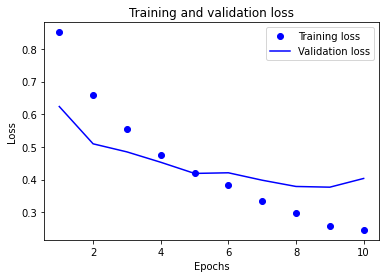

In [ ]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, (len(history.history['val_accuracy']) + 1))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# **MINI BATCH GRADIENT DESCENT**

In [ ]:
import tensorflow_addons as tfa
def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))
def accuracy1(y_true,y_pred):
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true) 
def eucliddist(X,y):
  dist =  K.sum(K.square(X - y), axis=1, keepdims=True)
  return dist
def euclid(values):
  X,y = values
  dist = eucliddist(X,y)
  return K.sqrt(K.maximum(dist, K.epsilon()))
def euclidshape(shapes):
  shape1, shape2 = shapes
  return (shape1[0], 1)
def loss1(Y_real,Y_predicted):
    # Y_predicted = tf.dtypes.cast(Y_predicted, tf.int64)
    # print(Y_predicted.dtype)
    # print(Y_real.dtype)
    margin = 1
    sqaureprediction = K.square(Y_predicted)
    marginsquare = K.square(K.maximum(margin - Y_predicted, 0))
    return K.mean(Y_real * sqaureprediction + (1 - Y_real) * marginsquare)
def paircreation(X,digitindices):
  pairs = []
  labels = []
  n = min([len(digitindices[d]) for d in range(10)]) - 1    
  i = 0
  while(i<10):
    j = 0
    while(j<n):
      z1 = digitindices[i][j]
      z2 = digitindices[i][j + 1]
      pairs += [[X[z1], X[z2]]]
      inc = random.randrange(1, 10)
      dn = (i + inc) % 10
      z1, z2 = digitindices[i][j], digitindices[dn][j]
      pairs += [[X[z1], X[z2]]]
      labels += [1, 0]    
      j = j+1
    i = i+1
  return np.array(pairs), np.array(labels)
def base_model(inputshape):
    input = Input(shape=inputshape)
    x = Dense(128, activation='relu')(input)
    x = Dense(128, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Lambda(lambda  x: K.l2_normalize(x,axis=1))(x)
    x = Lambda(lambda  x: K.l2_normalize(x,axis=1))(x)
    return Model(input,x)
digitindices = [np.where(Y_train == i)[0] for i in range(10)]
tr_pairs, tr_y = paircreation(X_train, digitindices)
tr_y = tr_y.astype("float32")
#print(tr_pairs,tr_y)
digitindices = [np.where(Y_test == i)[0] for i in range(10)]
te_pairs, te_y = paircreation(X_test, digitindices)
te_y = te_y.astype("float32")
#print(te_pairs,te_y)
modelbase = base_model(input_shape)
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)
processeda = modelbase(input_a)
processedb = modelbase(input_b)
distance = Lambda(euclid,output_shape=euclidshape)([processeda, processedb])
MOdel = Model([input_a, input_b], distance)    
sgd =  SGD(lr = 0.01, decay=1e-6, momentum=0.9 ,nesterov=True)
MOdel.compile(loss=tfa.losses.TripletSemiHardLoss(), optimizer=sgd, metrics=[accuracy])
history = MOdel.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,batch_size=128,epochs=10,validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))
y_pred_tr = MOdel.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
y_pred_te = MOdel.predict([te_pairs[:, 0], te_pairs[:, 1]])
trainaccuracy = accuracy1(tr_y, y_pred_tr)
testaccuracy = accuracy1(te_y, y_pred_te) 
print('* Accuracy on training set: %0.2f%%' % (100 * trainaccuracy))
print('* Accuracy on test set: %0.2f%%' % (100 * testaccuracy))


Epoch 1/10
847/847 [==============================] - 52s 61ms/step - loss: 0.9589 - accuracy: 0.7022 - val_loss: 0.7590 - val_accuracy: 0.8752
Epoch 2/10
847/847 [==============================] - 52s 61ms/step - loss: 0.8277 - accuracy: 0.8745 - val_loss: 0.6609 - val_accuracy: 0.9120
Epoch 3/10
847/847 [==============================] - 52s 62ms/step - loss: 0.7421 - accuracy: 0.9141 - val_loss: 0.5859 - val_accuracy: 0.9307
Epoch 4/10
847/847 [==============================] - 53s 62ms/step - loss: 0.6649 - accuracy: 0.9356 - val_loss: 0.5245 - val_accuracy: 0.9439
Epoch 5/10
847/847 [==============================] - 59s 69ms/step - loss: 0.6233 - accuracy: 0.9445 - val_loss: 0.5104 - val_accuracy: 0.9480
Epoch 6/10
847/847 [==============================] - 59s 69ms/step - loss: 0.5760 - accuracy: 0.9521 - val_loss: 0.5198 - val_accuracy: 0.9467
Epoch 7/10
847/847 [==============================] - 57s 67ms/step - loss: 0.5346 - accuracy: 0.9576 - val_loss: 0.4509 - val_accuracy:

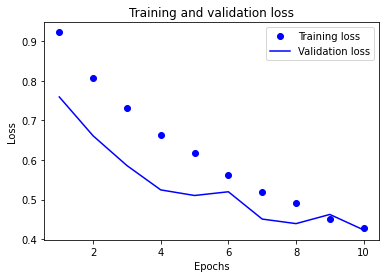

In [ ]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, (len(history.history['val_accuracy']) + 1))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# **ACCURACY COMPARISION AND HYPERPARAMETER TRAINING**

**ACCURACY OF ADAM - 96.55%**

**ACCURACY OF RMSprop - 96.21%** 

**ACCURACY OF MINI BATCH GRADIENT DESCENT - 95.56%**

*As we see ADAM has best accuracy as *

-**Requires little memory space**

-**Works well on problems with noisy or sparse gradients**

-**Works well with large data sets and large parameters**

**SINCE THE ACCURACY OF ADAM IS HIGHEST WE WILL HYPER PARAMETER TUNE ADAM**

**CHANGED HYPERPARAMTERS ARE AS FOLLOWS-**

**(lr=0.01, beta_1=0.9999, beta_2=0.999, epsilon=1e-08, decay=0.0)**

**Dense layer size changed from 128 to 256**

In [ ]:
import tensorflow_addons as tfa
def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))
def accuracy1(y_true,y_pred):
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true) 
def eucliddist(X,y):
  dist =  K.sum(K.square(X - y), axis=1, keepdims=True)
  return dist
def euclid(values):
  X,y = values
  dist = eucliddist(X,y)
  return K.sqrt(K.maximum(dist, K.epsilon()))
def euclidshape(shapes):
  shape1, shape2 = shapes
  return (shape1[0], 1)
def loss1(Y_real,Y_predicted):
    # Y_predicted = tf.dtypes.cast(Y_predicted, tf.int64)
    # print(Y_predicted.dtype)
    # print(Y_real.dtype)
    margin = 1
    sqaureprediction = K.square(Y_predicted)
    marginsquare = K.square(K.maximum(margin - Y_predicted, 0))
    return K.mean(Y_real * sqaureprediction + (1 - Y_real) * marginsquare)
def paircreation(X,digitindices):
  pairs = []
  labels = []
  n = min([len(digitindices[d]) for d in range(10)]) - 1    
  i = 0
  while(i<10):
    j = 0
    while(j<n):
      z1 = digitindices[i][j]
      z2 = digitindices[i][j + 1]
      pairs += [[X[z1], X[z2]]]
      inc = random.randrange(1, 10)
      dn = (i + inc) % 10
      z1, z2 = digitindices[i][j], digitindices[dn][j]
      pairs += [[X[z1], X[z2]]]
      labels += [1, 0]    
      j = j+1
    i = i+1
  return np.array(pairs), np.array(labels)
def base_model(inputshape):
    input = Input(shape=inputshape)
    x = Dense(128, activation='relu')(input)
    x = Dense(128, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Lambda(lambda  x: K.l2_normalize(x,axis=1))(x)
    x = Lambda(lambda  x: K.l2_normalize(x,axis=1))(x)
    return Model(input,x)
digitindices = [np.where(Y_train == i)[0] for i in range(10)]
tr_pairs, tr_y = paircreation(X_train, digitindices)
tr_y = tr_y.astype("float32")
#print(tr_pairs,tr_y)
digitindices = [np.where(Y_test == i)[0] for i in range(10)]
te_pairs, te_y = paircreation(X_test, digitindices)
te_y = te_y.astype("float32")
#print(te_pairs,te_y)
modelbase = base_model(input_shape)
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)
processeda = modelbase(input_a)
processedb = modelbase(input_b)
distance = Lambda(euclid,output_shape=euclidshape)([processeda, processedb])
MOdel = Model([input_a, input_b], distance)    
adm = keras.optimizers.Adam(lr=0.01, beta_1=0.99, beta_2=0.999, epsilon=1e-08, decay=0.0)
MOdel.compile(loss=tfa.losses.TripletSemiHardLoss(), optimizer=adm, metrics=[accuracy])
history = MOdel.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,batch_size=128,epochs=10,validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))
y_pred_tr = MOdel.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
y_pred_te = MOdel.predict([te_pairs[:, 0], te_pairs[:, 1]])



trainaccuracy = accuracy1(tr_y, y_pred_tr)
testaccuracy = accuracy1(te_y, y_pred_te) 
print('* Accuracy on training set: %0.2f%%' % (100 * trainaccuracy))
print('* Accuracy on test set: %0.2f%%' % (100 * testaccuracy))


Epoch 1/10
847/847 [==============================] - 43s 49ms/step - loss: 0.9269 - accuracy: 0.8395 - val_loss: 0.6969 - val_accuracy: 0.9094
Epoch 2/10
847/847 [==============================] - 41s 49ms/step - loss: 0.7618 - accuracy: 0.9162 - val_loss: 0.5567 - val_accuracy: 0.9412
Epoch 3/10
847/847 [==============================] - 42s 49ms/step - loss: 0.6808 - accuracy: 0.9404 - val_loss: 0.5409 - val_accuracy: 0.9443
Epoch 4/10
847/847 [==============================] - 41s 49ms/step - loss: 0.6017 - accuracy: 0.9511 - val_loss: 0.5255 - val_accuracy: 0.9463
Epoch 5/10
847/847 [==============================] - 41s 49ms/step - loss: 0.5446 - accuracy: 0.9599 - val_loss: 0.4679 - val_accuracy: 0.9542
Epoch 6/10
847/847 [==============================] - 41s 49ms/step - loss: 0.4789 - accuracy: 0.9642 - val_loss: 0.4370 - val_accuracy: 0.9568
Epoch 7/10
847/847 [==============================] - 42s 50ms/step - loss: 0.4673 - accuracy: 0.9667 - val_loss: 0.4385 - val_accuracy:

**ACCURACY BEFORE HYPERPARAMETER TUNING - 96.51%**

**ACCURACY AFTER HYPERPARAMETER TUNING - 97.61%**

# **PROS AND CONS OF SIAMESE NETWORK**

**PROS**

More Robust to class Imbalance: With the aid of One-shot learning, given a few images per class is sufficient for Siamese Networks to recognize those images in the future

Nice to an ensemble with the best classifier: Given that its learning mechanism is somewhat different from Classification, simple averaging of it with a Classifier can do much better than average 2 correlated Supervised models (e.g. GBM & RF classifier)

Learning from Semantic Similarity: Siamese focuses on learning embeddings (in the deeper layer) that place the same classes/concepts close together. Hence, can learn semantic similarity.

**CONS**

Needs more training time than normal networks: Since Siamese Networks involves quadratic pairs to learn from (to see all information available) it is slower than normal classification type of learning(pointwise learning)

Doesn’t output probabilities: Since training involves pairwise learning, it won’t output the probabilities of the prediction, but the distance from each class